In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 14 14:16:04 2020

@author: thomas
"""

#MODULES
import os,sys
import re
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
from scipy.signal import savgol_filter
import pathlib
from matplotlib import animation
from IPython.display import display, Image, HTML

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
%matplotlib inline

In [2]:
#CONSTANTS
cwd_PYTHON = os.getcwd()
PERIOD = 0.1
DT = 5.0e-3
RADIUSLARGE = 0.002
RADIUSSMALL = 0.001
FREQUENCY   = 10.0  

#Lists
#RLength
ReList=['0.5','0.6','0.7','0.8','0.9','1.0','2.0','3.0','4.0','5.0','7.5','10.0','12.5','15.0',
        '17.5','20.0','25.0','30.0','35.0','40.0','50.0','60.0']
allData = []

#### Obtain Pos Data for all simulations
#### Limit time to first five oscillations

In [3]:
def StoreData(cwd_POSDATA,Re):
    #global axAll
    #Reset position data every Sim
    pdData = []
    #Load position data
    pdData = pd.read_csv(cwd_POSDATA+'/pd.txt',delimiter=' ')
    #Save only every 20 rows (Every period)
    pdData = pdData.iloc[::20]
    #Reindex so index corresponds to period number
    pdData = pdData.reset_index(drop=True)
    #Print pdData to make sure it has been done properly
    #print(pdData.head(6))
    #Create Swimmer A and Swimmer B dataframes
    dict_A = {'xU':pdData['aXU'],'yU':pdData['aYU'],'xL':pdData['aXL'],'yL':pdData['aYL'],'time':pdData['time']}
    dataA  = pd.DataFrame(data=dict_A)
    dict_B = {'xU':pdData['bXU'],'yU':pdData['bYU'],'xL':pdData['bXL'],'yL':pdData['bYL'],'time':pdData['time']}
    dataB  = pd.DataFrame(data=dict_B)
    #Normalize Positions by small sphere radius (RADIUSSMALL)
    dataA['xU'] /= RADIUSSMALL
    dataA['yU'] /= RADIUSSMALL
    dataA['xL'] /= RADIUSSMALL
    dataA['yL'] /= RADIUSSMALL
    dataB['xU'] /= RADIUSSMALL
    dataB['yU'] /= RADIUSSMALL
    dataB['xL'] /= RADIUSSMALL
    dataB['yL'] /= RADIUSSMALL
    #print(dataA)
    #print(dataB)
    #Create a swimmer class for each
    swimA = Swimmer(dataA)
    swimB = Swimmer(dataB)
    simTime = swimA.time
    
    #Create a Combined Swimmer Class
    swimmer = CombinedSwimmer(swimA,swimB)
    #Displace swimA and swimB coords by swimmer.CM
    #Rotate swimA and swimB coords by combined theta
    swimA.DisplaceRotate(swimmer.CM,swimmer.theta)
    swimB.DisplaceRotate(swimmer.CM,swimmer.theta)
    #Now we have all times rotated and displaced by combined swimmer CM
    #We can now plot for each time step the shape created by these transformed coordinates
    for idx in range(len(simTime)):
        #First create a coordinate list
        coords = [[swimA.U_s[0,idx],swimA.U_s[1,idx]], [swimA.L_s[0,idx],swimA.L_s[1,idx]], 
                  [swimB.L_s[0,idx],swimB.L_s[1,idx]], [swimB.U_s[0,idx],swimB.U_s[1,idx]],]
        coords.append(coords[0]) #Complete loop
        xS, yS = zip(*coords)
        #Next Plot the coordinate list
        PlotSwimmerShape(xS,yS,idx,Re)

    return

In [4]:
def PlotSwimmerShape(x,y,idx,Re):
    csfont = {'fontname':'Times New Roman'}
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4),dpi=200)
    ax.set_title('Swimmer shape: Swimming Frame: Re = %s'%Re,fontsize=12,**csfont)
    ax.plot([0.0,0.0],[-7.5,7.5],c='k',ls='--')
    ax.plot([-7.5,7.5],[0.0,0.0],c='k',ls='--')
    ax.plot(x,y,c='r',lw=2)
    ax.plot(x[0:2],y[0:2],c='k',lw=2,zorder=3)
    ax.plot(x[2:4],y[2:4],c='b',lw=2,zorder=3)
    ax.axis([-7.5,7.5,-7.5,7.5])
    ax.set_aspect('equal')
    fig.tight_layout()
    strDir = cwd_PYTHON+'/../Figures/V/SwimmerShape/Re%s/'%Re
    pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
    fig.savefig(strDir+'swimshape_%i.png'%idx)
    if(idx%10 == 0):
        print('idx = ',idx)
    fig.clf()
    plt.close()
    return

In [5]:
def Rotate(xy, theta):
    # https://en.wikipedia.org/wiki/Rotation_matrix#In_two_dimensions
    #First Rotate based on Theta
    #Allocate Arrays
    rotationMatrix = np.zeros((2,2))
    #Calculate rotation matrix
    rotationMatrix[0,0] = np.cos(theta)
    rotationMatrix[0,1] = -1.0*np.sin(theta)
    rotationMatrix[1,0] = np.sin(theta)
    rotationMatrix[1,1] = np.cos(theta) 
    return rotationMatrix.dot(xy)

def Translate(xy, offset):
    return xy + offset

class CombinedSwimmer:
    def __init__(self,A,B):
        self.ACM = A.CM
        self.BCM = B.CM
        self.CM = np.zeros((2,len(A.time)))
        self.norm = np.zeros((2,len(A.time)))
        self.theta = np.zeros(len(A.time))
        self.CalcCM()
        self.CalcLabAngle(A,B)
        return
    
    def CalcCM(self):
        self.CM[0] = 0.5*(self.ACM[0]+self.BCM[0])
        self.CM[1] = 0.5*(self.ACM[1]+self.BCM[1])
        return
    
    def CalcLabAngle(self,A,B):
        self.UxCM = 0.5*(A.xU + B.xU)
        self.UyCM = 0.5*(A.yU + B.yU)
        self.LxCM = 0.5*(A.xL + B.xL)
        self.LyCM = 0.5*(A.yL + B.yL)
        self.labX = self.UxCM - self.LxCM
        self.labY = self.UyCM - self.LyCM
        self.length = np.hypot(self.labX,self.labY)
        self.norm[0,:] = self.labX/self.length
        self.norm[1,:] = self.labY/self.length
        self.theta = np.arctan2(self.norm[1,:],self.norm[0,:]) - np.pi/2.0 #Reference angle is when norm points straight up
        return
    

class Swimmer:
    def __init__(self,data):
        self.data  = data
        self.xU, self.yU = data['xU'], data['yU']
        self.xL, self.yL = data['xL'], data['yL']
        self.time = data['time']/2.0
        self.CM = np.zeros((2,len(self.time)))
        self.U_s = np.zeros((2,len(self.time)))
        self.L_s = np.zeros((2,len(self.time)))
        self.CalcCM()
        
    def CalcCM(self):
        self.xCM = 0.8*self.xU + 0.2*self.xL
        self.yCM = 0.8*self.yU + 0.2*self.yL
        self.CM[0] = self.xCM
        self.CM[1] = self.yCM
        #print('CM = ',self.CM)
        
    def DisplaceRotate(self,CM_comb,theta_comb):
        self.xU_temp, self.yU_temp = self.xU - CM_comb[0], self.yU - CM_comb[1]
        self.xL_temp, self.yL_temp = self.xL - CM_comb[0], self.yL - CM_comb[1]
        #Combine x and y to make vector
        self.U_temp = np.zeros((2,len(self.time)))
        self.L_temp = np.zeros((2,len(self.time)))
        self.U_temp[0], self.U_temp[1] = self.xU_temp, self.yU_temp
        self.L_temp[0], self.L_temp[1] = self.xL_temp, self.yL_temp
        for idx in range(len(self.time)):
            self.U_s[:,idx] = Rotate(self.U_temp[:,idx],-1.0*theta_comb[idx])
            self.L_s[:,idx] = Rotate(self.L_temp[:,idx],-1.0*theta_comb[idx])
        return

In [6]:
#The main goal of this script is to create images and movies of the swimming shape (Represented by a quadilateral)
#1) For each simulation, store position data for every period (nothing in between)
#2) Calculate CM and Angle of combined swimming formation
#3) Rotate and Displace lab frame coordinates to combined swimmer coordinates
#4) Construct coordinates for each sphere and zip to make connections
#5) Plot Shape for each period
#6) ffmpeg to mkae a movie of the shape evolution

count = 0
for Re in ReList:
    cwd_POSDATA = cwd_PYTHON+'/../PosData/V/Re'+Re+'/'
    strPrint = 'Re:'+Re
    print(strPrint)
    StoreData(cwd_POSDATA,Re)
    count += 1
print('count = ',count)
print('Storing, Calculating, and Plotting is Complete! Now lets make the movies!')
                

Re:0.5
idx =  0
idx =  10
idx =  20
idx =  30
idx =  40
idx =  50
idx =  60
idx =  70
idx =  80
idx =  90
idx =  100
idx =  110
idx =  120
idx =  130
idx =  140
Re:0.6
idx =  0
idx =  10
idx =  20
idx =  30
idx =  40
idx =  50
idx =  60
idx =  70
idx =  80
idx =  90
idx =  100
idx =  110
idx =  120
idx =  130
idx =  140
idx =  150
idx =  160
idx =  170
idx =  180
Re:0.7
idx =  0
idx =  10
idx =  20
idx =  30
idx =  40
idx =  50
idx =  60
idx =  70
idx =  80
idx =  90
idx =  100
idx =  110
idx =  120
idx =  130
idx =  140
idx =  150
idx =  160
idx =  170
Re:0.8
idx =  0
idx =  10
idx =  20
idx =  30
idx =  40
idx =  50
idx =  60
idx =  70
idx =  80
idx =  90
idx =  100
idx =  110
idx =  120
idx =  130
idx =  140
idx =  150
idx =  160
Re:0.9
idx =  0
idx =  10
idx =  20
idx =  30
idx =  40
idx =  50
idx =  60
idx =  70
idx =  80
idx =  90
idx =  100
idx =  110
idx =  120
idx =  130
idx =  140
idx =  150
idx =  160
idx =  170
idx =  180
idx =  190
idx =  200
Re:1.0
idx =  0
idx =  10
idx 

(1, 2, 2, 1, 0.5, 1)


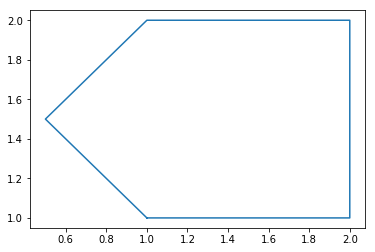

In [2]:
import matplotlib.pyplot as plt


coord = [[1,1], [2,1], [2,2], [1,2], [0.5,1.5]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values
print(xs)

plt.figure()
plt.plot(xs,ys)
plt.show()